<a href="https://colab.research.google.com/github/Szuyingpan/NLP-Project-RoBERTa/blob/main/AmazonReviews_Sentiment_Analysis_by_Using_RoBERSTa_LastTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup environment

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Library

In [6]:
import bz2

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import softmax

from tqdm.notebook import tqdm

# add this for pandas, to better look at the data
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

## 2. Impost data

In [12]:
import pandas as pd

NUMBER_OF_LINES = 2000

data = {}

# Counter to keep track of the number of processed lines
i = 0

# Open the file and read line by line
with open('/content/drive/MyDrive/Colab Notebooks/train.ft.txt', 'r', encoding='utf-8') as file:
    for line in file:
        # Check if we have processed the desired number of lines
        if i == NUMBER_OF_LINES:
            break

        # Determine the label based on the line prefix
        label = 1 if line[:10] == "__label__1" else 2

        # Extract the text, removing the label part
        text = line[10:].strip() # Also strip to remove leading/trailing whitespaces

        # Store the processed line in the dictionary
        data[i] = {"label": label, "text": text}

        # Increment the counter
        i += 1

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(data, orient='index')
df = df.reset_index().rename(columns={"index": "Id"})

# Display the first few rows of the DataFrame to verify
print(df.head())


   Id  label                                               text
0   0      2  Stuning even for the non-gamer: This sound tra...
1   1      2  The best soundtrack ever to anything.: I'm rea...
2   2      2  Amazing!: This soundtrack is my favorite music...
3   3      2  Excellent Soundtrack: I truly like this soundt...
4   4      2  Remember, Pull Your Jaw Off The Floor After He...


    Id  label                                               text
0    0      2  Stuning even for the non-gamer: This sound tra...
1    1      2  The best soundtrack ever to anything.: I'm rea...
2    2      2  Amazing!: This soundtrack is my favorite music...
3    3      2  Excellent Soundtrack: I truly like this soundt...
4    4      2  Remember, Pull Your Jaw Off The Floor After He...
5    5      2  an absolute masterpiece: I am quite sure any o...
6    6      1  Buyer beware: This is a self-published book, a...
7    7      2  Glorious story: I loved Whisper of the wicked ...
8    8      2  A FIVE STAR BOOK: I just finished reading Whis...
9    9      2  Whispers of the Wicked Saints: This was a easy...
10  10      1  The Worst!: A complete waste of time. Typograp...
11  11      2  Great book: This was a great book,I just could...
12  12      2  Great Read: I thought this book was brilliant,...
13  13      1  Oh please: I guess you have to be a romance no...
14  14      1  Awful beyo

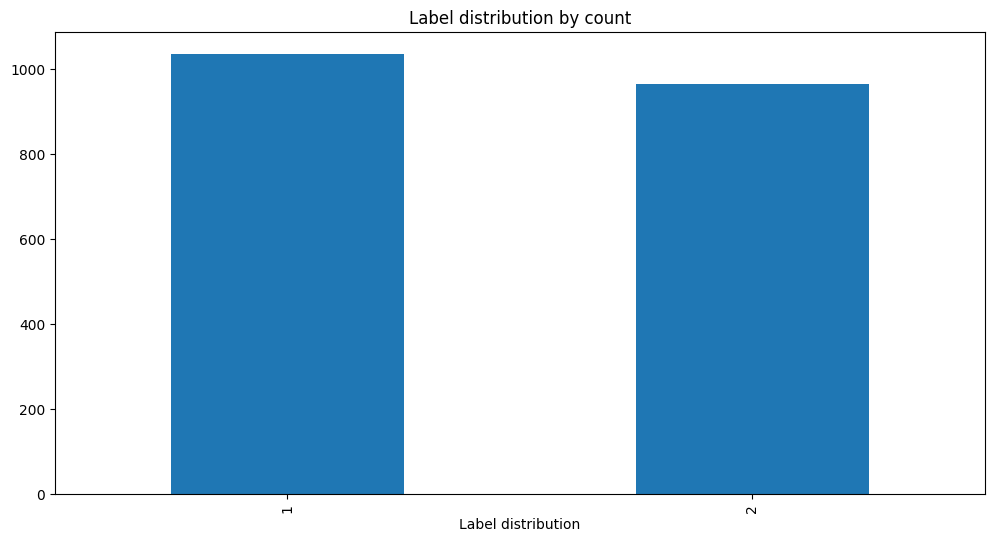

In [13]:
print(df.head(20))

print("the shape of the data", df.shape)

print("unique labels", df["label"].unique())

valueCounts = df["label"].value_counts().sort_index()
print(valueCounts)

ax = valueCounts.plot(kind="bar", title="Label distribution by count", figsize=(12, 6))
ax.set_xlabel("Label distribution")
plt.show()

## 3. Semtiment prediction with RoBERTa transformer

In [14]:
modelName = "cardiffnlp/twitter-roberta-base-sentiment" # using pre-trained model from Hugging Face Transformer

# here we instantiate the token and the model for our defined model name
myTokenizer = AutoTokenizer.from_pretrained(modelName, max_length=512)
myModel = AutoModelForSequenceClassification.from_pretrained(modelName, max_length=512)

robertaResults = {} # initialized to store the sentiment analysis results

# using a loop "tqdm" iterates over each row of the DataFrame "df"
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["text"]

    """ first we create the tokens from the input text,
    return_tensors="pt" means output should be PyTorch tensors,
    and ensures that texts longer than 512 tokens are truncated"""

    tokens = myTokenizer.__call__(text, return_tensors="pt", max_length=512, truncation=True)

    # next we apply the tokens to our model
    out = myModel.__call__(**tokens)

    """ here we get the actual scores from the tensors.
    extracts the logits for the first (and only) input in the batch,
    detaches them from the computation graph, and converts them to a NumPy array."""
    scores = out[0][0].detach().numpy()

    """ applies the softmax function to the logits, converting them into probabilities.
    there are three values, the first is the negative, neutral, positive."""
    softScores = softmax(scores)

    # create a map with the results
    robertaScores = {
        "roberta_negative": softScores[0],
        "roberta_neutral": softScores[1],
        "roberta_positive": softScores[2],
        "predicted_label": 1 if softScores[0] > softScores[2] else 2
    }

    # add the local scores to all the results
    robertaResults[i] = robertaScores

# create a pandas data frame from the parsed map
robertaDf = pd.DataFrame(robertaResults).T

# This DataFrame is then merged with the original DataFrame df to align each text with its sentiment analysis results,
# resulting in sentimentDf.
robertaDf = robertaDf.reset_index().rename(columns= {"index": "Id"})

sentimentDf = robertaDf.merge(df, how="left")

print(sentimentDf.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

   Id  roberta_negative  roberta_neutral  roberta_positive  predicted_label  label                                               text
0   0          0.003296         0.014339          0.982364              2.0      2  Stuning even for the non-gamer: This sound tra...
1   1          0.008890         0.053305          0.937805              2.0      2  The best soundtrack ever to anything.: I'm rea...
2   2          0.003940         0.021520          0.974540              2.0      2  Amazing!: This soundtrack is my favorite music...
3   3          0.001481         0.027240          0.971279              2.0      2  Excellent Soundtrack: I truly like this soundt...
4   4          0.001758         0.016666          0.981577              2.0      2  Remember, Pull Your Jaw Off The Floor After He...


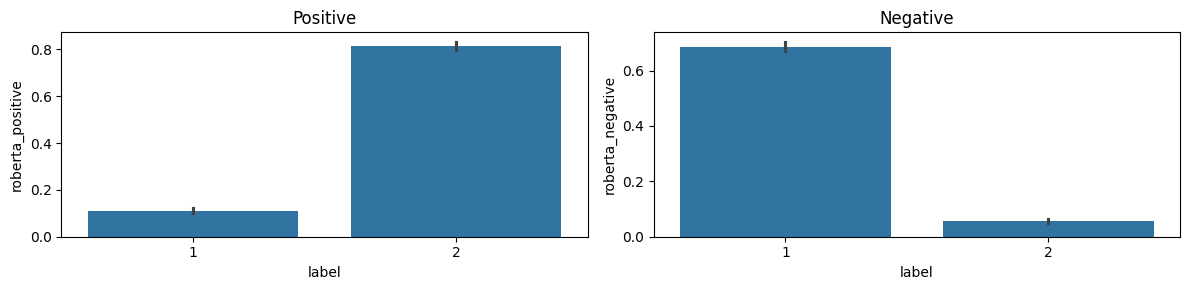

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
sns.barplot(data=sentimentDf, x='label', y='roberta_positive', ax=axs[0])
sns.barplot(data=sentimentDf, x='label', y='roberta_negative', ax=axs[1])
axs[0].set_title('Positive')
axs[1].set_title('Negative')
plt.tight_layout()
plt.show()

In [16]:
correct = 0

for i, row in sentimentDf.iterrows():

    if row["label"] == int(row["predicted_label"]):
        correct += 1


accuracy = correct / len(sentimentDf)
print(f"accuracy is {accuracy}")


accuracy is 0.904
